In [1]:
import os
from PIL import Image
from transformers import  AutoProcessor, AutoModelForVision2Seq

In [12]:
#MP = "J:/model/mllm-model/microsoft-kosmos-2-patch14-224"
MP = "J:/model/mllm-model/ydshieh-kosmos-2-patch14-224"
image_path = os.path.join(MP, "snowman.jpg")

In [8]:
model = AutoModelForVision2Seq.from_pretrained(MP, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(MP, trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
prompt = "<grounding>An image of"

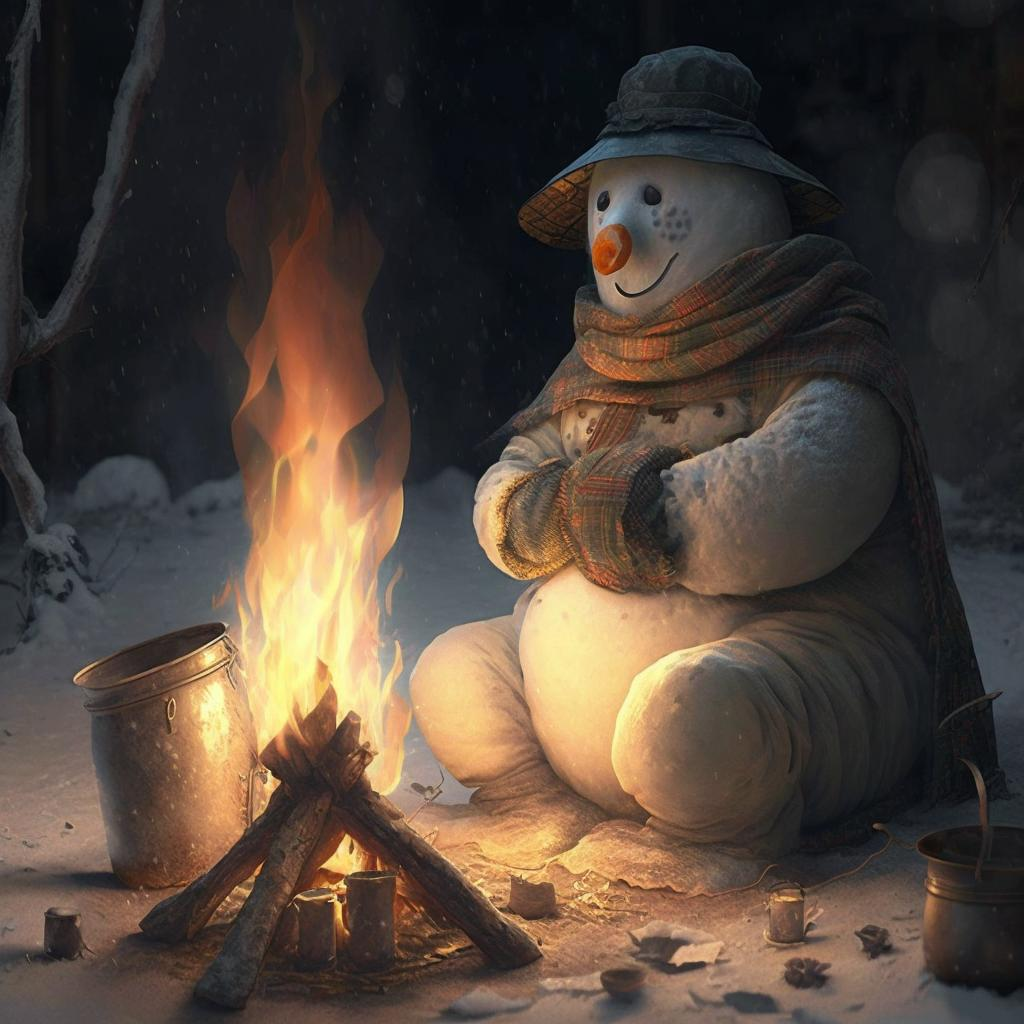

In [15]:
image = Image.open(image_path).convert("RGB")
display(image)

In [18]:
inputs = processor(text=prompt, images=image, return_tensors="pt")
inputs

{'input_ids': tensor([[    0, 64003,     4,     5,     6,     7,     8,     9,    10,    11,
            12,    13,    14,    15,    16,    17,    18,    19,    20,    21,
            22,    23,    24,    25,    26,    27,    28,    29,    30,    31,
            32,    33,    34,    35,    36,    37,    38,    39,    40,    41,
            42,    43,    44,    45,    46,    47,    48,    49,    50,    51,
            52,    53,    54,    55,    56,    57,    58,    59,    60,    61,
            62,    63,    64,    65,    66,    67, 64004, 64012,   712,  1648,
             9,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'pixel_values': tensor([[[[-1.6171, -1.6171, -1.5879,  ..., -1.4857, -1.5295, -1.5441],
          [-1.6171, -1.6171, -1.6025,  ..., -1.5295, -1

In [21]:
generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids = inputs["input_ids"][:, :-1],
    attention_mask = inputs["attention_mask"][:, :-1],
    img_features = None,
    img_attn_mask = inputs["img_attn_mask"][:, :-1],
    use_cache = True,
    max_new_tokens = 64,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


In [22]:
generated_ids, generated_text

(tensor([[    0, 64003,     4,     5,     6,     7,     8,     9,    10,    11,
             12,    13,    14,    15,    16,    17,    18,    19,    20,    21,
             22,    23,    24,    25,    26,    27,    28,    29,    30,    31,
             32,    33,    34,    35,    36,    37,    38,    39,    40,    41,
             42,    43,    44,    45,    46,    47,    48,    49,    50,    51,
             52,    53,    54,    55,    56,    57,    58,    59,    60,    61,
             62,    63,    64,    65,    66,    67, 64004, 64012,   712,  1648,
              9, 64007,    10, 43867, 64008, 64009, 64057, 64876, 64010,  5950,
            597,    32, 64007,    10,   646, 64008, 64009, 64018, 64924, 64010,
              4,     2]]),
 '<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An i

In [31]:
# By default, the generated  text is cleanup and the entities are extracted.
_processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
processed_text, entities = processor.post_process_generation(generated_text)


In [34]:
print(_processed_text + "\n")
print(processed_text + "\n")
print(entities)

<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming himself by<phrase> a fire</phrase><object><patch_index_0005><patch_index_0911></object>.

An image of a snowman warming himself by a fire.

[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]


#### Draw the bounding bboxes of the entities on the image
Once you have the entities, you can use the following helper function to draw their bounding bboxes on the image:

In [26]:
import cv2
import numpy as np
import os
import requests
import torch
import torchvision.transforms as T

from PIL import Image

In [27]:
def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)

In [28]:

def draw_entity_boxes_on_image(image, entities, show=False, save_path=None):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    elif isinstance(image, str):
        if os.path.exists(image):
            pil_img = Image.open(image).convert("RGB")
            image = np.array(pil_img)[:, :, [2, 1, 0]]
            image_h = pil_img.height
            image_w = pil_img.width
        else:
            raise ValueError(f"invaild image path, {image}")
    elif isinstance(image, torch.Tensor):
        # pdb.set_trace()
        image_tensor = image.cpu()
        reverse_norm_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        reverse_norm_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])[:, None, None]
        image_tensor = image_tensor * reverse_norm_std + reverse_norm_mean
        pil_img = T.ToPILImage()(image_tensor)
        image_h = pil_img.height
        image_w = pil_img.width
        image = np.array(pil_img)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, (start, end), bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])
    if save_path:
        pil_image.save(save_path)
    if show:
        pil_image.show()

    return new_image

In [30]:
# Draw the bounding bboxes
new_image = draw_entity_boxes_on_image(image, entities, show=True)

In [37]:
# 整理成函数
def run_example(prompt, image):

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"][:, :-1],
        attention_mask=inputs["attention_mask"][:, :-1],
        img_features=None,
        img_attn_mask=inputs["img_attn_mask"][:, :-1],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    _processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
    processed_text, entities = processor.post_process_generation(generated_text)
    print(processed_text)
    print(entities)
    print(_processed_text)

In [38]:
prompt = "<grounding><phrase> a snowman</phrase>"
run_example(prompt, image)

a snowman sitting by a campfire in the snow
[('a snowman', (0, 9), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a campfire', (21, 31), [(0.140625, 0.015625, 0.515625, 0.984375)])]
<grounding><phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> sitting by<phrase> a campfire</phrase><object><patch_index_0004><patch_index_1008></object> in the snow


Perception-Language Tasks
• Grounded VQA

In [40]:
prompt = "<grounding> Question: What is special about this image? Answer:"
run_example(prompt, image)

Question: What is special about this image? Answer: The image features a snowman sitting by a campfire in the snow.
[('a snowman', (71, 80), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a campfire', (92, 102), [(0.140625, 0.015625, 0.515625, 0.984375)])]
<grounding> Question: What is special about this image? Answer: The image features<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> sitting by<phrase> a campfire</phrase><object><patch_index_0004><patch_index_1008></object> in the snow.


• Grounded VQA with multimodal referring via bounding boxes

In [41]:
prompt = "<grounding> Question: Where is<phrase> the fire</phrase><object><patch_index_0005><patch_index_0911></object> next to? Answer:"
run_example(prompt, image)

Question: Where is the fire next to? Answer: Near the snowman.
[('the fire', (19, 27), [(0.171875, 0.015625, 0.484375, 0.890625)]), ('the snowman', (50, 61), [(0.390625, 0.046875, 0.984375, 0.828125)])]
<grounding> Question: Where is<phrase> the fire</phrase><object><patch_index_0005><patch_index_0911></object> next to? Answer: Near<phrase> the snowman</phrase><object><patch_index_0044><patch_index_0863></object>.


Grounded Image captioning
• Brief

In [42]:
prompt = "<grounding> An image of"
run_example(prompt, image)

An image of a snowman warming himself by a fire.
[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]
<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming himself by<phrase> a fire</phrase><object><patch_index_0005><patch_index_0911></object>.


• Detailed

In [43]:
prompt = "<grounding> Describe this image in detail:"
run_example(prompt, image)

Describe this image in detail: The image features a snowman sitting by a campfire in the snow. He is wearing a hat, scarf, and gloves, with a pot nearby and a cup
[('a campfire', (71, 81), [(0.171875, 0.015625, 0.484375, 0.984375)]), ('a hat', (109, 114), [(0.515625, 0.046875, 0.828125, 0.234375)]), ('scarf', (116, 121), [(0.515625, 0.234375, 0.890625, 0.578125)]), ('gloves', (127, 133), [(0.515625, 0.390625, 0.640625, 0.515625)]), ('a pot', (140, 145), [(0.078125, 0.609375, 0.265625, 0.859375)])]
<grounding> Describe this image in detail: The image features a snowman sitting by<phrase> a campfire</phrase><object><patch_index_0005><patch_index_1007></object> in the snow. He is wearing<phrase> a hat</phrase><object><patch_index_0048><patch_index_0250></object>,<phrase> scarf</phrase><object><patch_index_0240><patch_index_0604></object>, and<phrase> gloves</phrase><object><patch_index_0400><patch_index_0532></object>, with<phrase> a pot</phrase><object><patch_index_0610><patch_index_0872

Running the Flask Server
flask_kosmos2.py shows the implementation of a Flask server for the model. It allowes the model to be approached as a REST API.

After starting the server. You can send a POST request to http://localhost:8005/process_prompt with the following form data:

prompt: For example <grounding> an image of
image: The image file as binary data
This in turn will produce a reply with the following JSON format:

message: The Kosmos-2 generated text
entities: The extracted entities
An easy way to test this is through an application like Postman. Make sure the image field is set to File.